# Week 4: Lasso

The purpose of this week's exercises is to get our hands dirty using tools for high-dimensional estimation. We will here focus on the Lasso. However, most if not all exercises below can be done for the Ridge estimator, Dantzig selector, and the Elastic Net. (Do it!) We will use the "housing.csv" dataset, which contains data on house prices and more across districts in California. 

(The dataset is a slightly modified version of one initially featured in the paper "Sparse spatial autoregressions" by Pace and Barry in Statistics & Probability Letters 33.3 (1997), pp. 291-297. The data derive from the 1990 census, so it will sadly not help you predict current house prices)

We first read the data into Python and explore the dataset to begin with.

In [1]:
# Read data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
growth = pd.read_csv("growth.csv")
print("The number of rows and columns are {} and also called shape of the matrix".format(growth.shape))  # data dimensions
print("Columns names are: {}".format(growth.columns.to_list()))

# Keep backward compatibility with downstream cells expecting `housing`
housing = growth

The number of rows and columns are (214, 85) and also called shape of the matrix
Columns names are: ['code', 'marketref', 'dem', 'demCGV', 'demBMR', 'demreg', 'lp_bl', 'ls_bl', 'lh_bl', 'tropicar', 'distcr', 'distc', 'distr', 'ginv', 'polity', 'polity2', 'landlock', 'yellow', 'oilres', 'goldm', 'iron', 'silv', 'zinc', 'mortality', 'imputedmort', 'logem4', 'excolony', 'lt100km', 'democ1', 'democ00a', 'cons00a', 'currentinst', 'imr95', 'leb95', 'malfal', 'uvdamage', 'suitavg', 'pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa', 'pd1', 'pd1000', 'pd1500', 'pd1500.1', 'pop1', 'pop1000', 'pop1500', 'legor_uk', 'legor_fr', 'temp', 'elevavg', 'elevstd', 'kgatr', 'precip', 'suitgini', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'ln_yst', 'ln_yst_aa', 'africa', 'europe', 'asia', 'oceania', 'americas', 'pprotest', 'pcatholic', 'pmuslim', 'pother', 'population_initial', 'population_now', 'gdp_pc_initial', 'gdp_pc_now', 'capital_growth_pct_gdp_initial', 'capital_growth_pct_gdp_now', 'gdp_initial', 'g

In [2]:
print(growth.head()) # first observations

  code  marketref  dem  demCGV  demBMR    demreg      lp_bl      ls_bl  \
0  AFG        NaN  0.0     0.0     0.0  0.000000   4.109822   0.564805   
1  AGO        NaN  NaN     NaN     NaN  0.031250        NaN        NaN   
2  ALB   9.090906  0.0     0.0     0.0  0.037037  32.111988  32.864277   
3  ARE        NaN  NaN     NaN     NaN       NaN        NaN        NaN   
4  ARG  34.144062  0.0     0.0     0.0  0.071429  72.400000  15.300000   

      lh_bl  tropicar  ...   gdp_pc_now  capital_growth_pct_gdp_initial  \
0  1.096088  0.000000  ...   549.391787                        5.463794   
1       NaN  1.000000  ...  2890.892897                             NaN   
2  2.935904  0.000000  ...  5064.061916                             NaN   
3       NaN       NaN  ...          NaN                             NaN   
4  4.000000  0.027089  ...  8692.708046                       24.440095   

   capital_growth_pct_gdp_now   gdp_initial       gdp_now  investment_rate  \
0                         

In [3]:
print(growth.tail()) # last observations

    code  marketref  dem  demCGV  demBMR  demreg  lp_bl  ls_bl  lh_bl  \
209  PYF        NaN  NaN     NaN     NaN     NaN    NaN    NaN    NaN   
210  SMR        NaN  NaN     NaN     NaN     NaN    NaN    NaN    NaN   
211  TMP        NaN  NaN     NaN     NaN     NaN    NaN    NaN    NaN   
212  VIR        NaN  NaN     NaN     NaN     NaN    NaN    NaN    NaN   
213  WBG        NaN  NaN     NaN     NaN     NaN    NaN    NaN    NaN   

     tropicar  ...  gdp_pc_now  capital_growth_pct_gdp_initial  \
209       NaN  ...         NaN                             NaN   
210       NaN  ...         NaN                             NaN   
211       NaN  ...         NaN                             NaN   
212       NaN  ...         NaN                             NaN   
213       NaN  ...         NaN                             NaN   

     capital_growth_pct_gdp_now  gdp_initial  gdp_now  investment_rate  \
209                         NaN          NaN      NaN              NaN   
210             

In [4]:
print(growth.dtypes) # data types

code                object
marketref          float64
dem                float64
demCGV             float64
demBMR             float64
                    ...   
investment_rate    float64
gdp_growth         float64
pop_growth         float64
lgdp_initial       float64
lpop_initial       float64
Length: 85, dtype: object


In [5]:
growth.isnull().sum() # check for missing values

code                 0
marketref           78
dem                 59
demCGV              64
demBMR              60
                  ... 
investment_rate     35
gdp_growth         112
pop_growth          16
lgdp_initial       105
lpop_initial        15
Length: 85, dtype: int64

Some observations are missing a bedroom count. We here drop those. (An alternative approach is to impute the mean or median value and use all observations. Do it!)

In [6]:
growth=growth.dropna()
growth.isnull().sum()

code               0
marketref          0
dem                0
demCGV             0
demBMR             0
                  ..
investment_rate    0
gdp_growth         0
pop_growth         0
lgdp_initial       0
lpop_initial       0
Length: 85, dtype: int64

We will model house prices (median_house_value) using a linear (in the parameters) model of the remaining basic regressors minus "ocean_proximity". (The latter variable is likely a predictor of house prices. However, due to its categorical nature, we will exclude it for the purpose of this exercise. A better  approach is to convert this categorical variable into a collection of dummies.)

In [7]:
# Use growth data
y = growth['gdp_growth']
X = growth.drop(columns=['gdp_growth', 'code'])

# Keep complete cases
mask = y.notna() & X.notna().all(axis=1)
X = X.loc[mask]
y = y.loc[mask]

Xnames = X.columns
print(X.head())

    marketref  dem  demCGV  demBMR    demreg      lp_bl      ls_bl     lh_bl  \
4   34.144062  0.0     0.0     0.0  0.071429  72.400000  15.300000  4.000000   
22  23.809525  0.0     0.0     0.0  0.071429  46.000000   9.600000  2.000000   
30  26.492008  1.0     1.0     1.0  0.875000  57.200000  26.600000  3.800000   
33   0.000000  0.0     0.0     0.0  0.032258  21.448267   3.273951  0.218137   
35  10.119047  1.0     1.0     1.0  0.875000  56.823887  12.395759  1.942384   

    tropicar   distcr  ...  gdp_pc_initial    gdp_pc_now  \
4   0.027089  271.642  ...     7084.180589   8692.708046   
22  0.931233  315.764  ...     4704.317561  10672.177739   
30  0.185873  112.301  ...     4552.255588  14050.176184   
33  1.000000  405.651  ...      930.990262   1490.829641   
35  1.000000  200.267  ...     2879.251257   7228.436546   

    capital_growth_pct_gdp_initial  capital_growth_pct_gdp_now   gdp_initial  \
4                        24.440095                   13.776598  1.691742e+11  

# Exercises

### Question 1: Standardization
Standardize the candidate regressors to bring everything onto the same scale. 

*Note 1:* One way is to use the functions mean() and std() from numpy

In [8]:
def standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_tilde = (X - mu)/sigma
    return X_tilde

X_tilde=standardize(X)

### Question 2: Penalty Grid
Construct a grid of 50 candidate penalty levels from 0.01 to 80000, and estimate the linear model for each of these penalty levels while saving the coefficient estimates.

*Note 1:* Use np.geomspace to create a log scaled grid of penalty levels. 

*Note 2:* Use sklearn.linear_model.Lasso to estimate using Lasso. This is already loaded in as Lasso. The syntax is Lasso(alpha=penalty_level).fit(x,y) to get a "container" of results from the estimation. Read more about the Lasso function here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html.

In [10]:
# Data-driven grid (sklearn objective: (1/(2n))||y-Xb||^2 + alpha||b||_1)
n = len(y)

# Drop zero-variance predictors before standardizing to avoid NaNs/Infs
var_mask = X.std(axis=0) != 0
X_tilde = standardize(X.loc[:, var_mask])

# Center y
y_c = y - y.mean()

# alpha_max for sklearn's Lasso: (1/n) * ||X^T y||_inf on standardized X
Xt_y = X_tilde.to_numpy().T @ y_c.to_numpy()
alpha_max = np.abs(Xt_y).max() / n

# Fallback in case of numerical issues
if not np.isfinite(alpha_max) or alpha_max <= 0:
    alpha_max = 1.0

penalty_grid = np.geomspace(alpha_max, alpha_max/1e4, 50)

coefs = []
for lamb in penalty_grid:
    fit = Lasso(alpha=lamb).fit(X_tilde, y)
    coefs.append(fit.coef_)

/Users/juliusvikjaer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.388e-07, tolerance: 1.434e-07
  model = cd_fast.enet_coordinate_descent(
/Users/juliusvikjaer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.939e-07, tolerance: 1.434e-07
  model = cd_fast.enet_coordinate_descent(
/Users/juliusvikjaer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

### Question 3: Lasso Path

Plot the (standardized) coefficient estimates as a function of the penalty level, i.e.
create what is known as the Lasso path. 

*Note 1:* Don't worry about the vlines for now.

In [11]:
def plot_lasso_path(penalty_grid, coefs, legends, vlines: dict = None):
    """
    Plot Lasso coefficient paths for the GDP growth model.

    Parameters:
    penalty_grid (array-like): Penalty parameter values (alphas).
    coefs (array-like): Sequence (len=|penalty_grid|) of coefficient vectors.
    legends (list-like): Feature names corresponding to the coefficients.
    vlines (dict, optional): {label: penalty_value} to annotate vertical lines.
    """
    fig, ax = plt.subplots()

    coef_path = np.asarray(coefs)  # shape: (n_alphas, p)
    ax.plot(penalty_grid, coef_path)

    ax.set_xscale('log')
    ax.set_xlabel('Penalty, $\\lambda$')
    ax.set_ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    ax.set_title('Lasso Path (GDP growth)')

    # Legend (truncate to number of series if needed)
    p = coef_path.shape[1] if coef_path.ndim == 2 else 0
    if legends is not None and p:
        names = list(legends)
        if len(names) != p:
            names = names[:p]
        ax.legend(names, loc=(1.04, 0), fontsize='small')

    # Vertical lines with dynamic y placement
    if vlines:
        ymin, ymax = ax.get_ylim()
        ytext = ymin + 0.02 * (ymax - ymin)
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            ax.text(penalty, ytext, name, rotation=90, va='bottom', ha='center', color='grey')

    plt.show()
    plt.close()


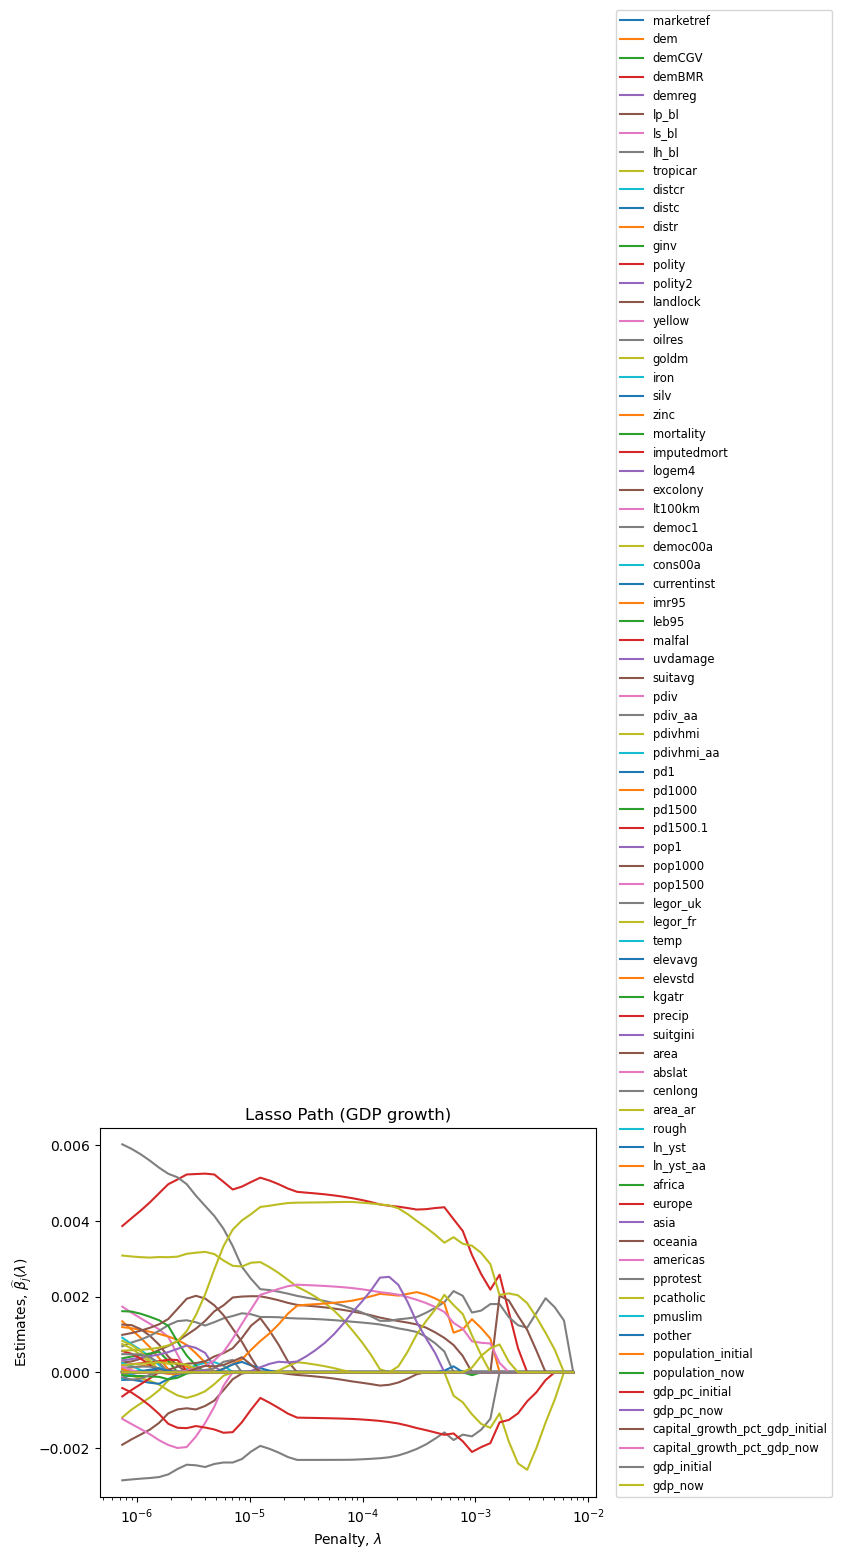

In [12]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames)

You should get something that looks like this:

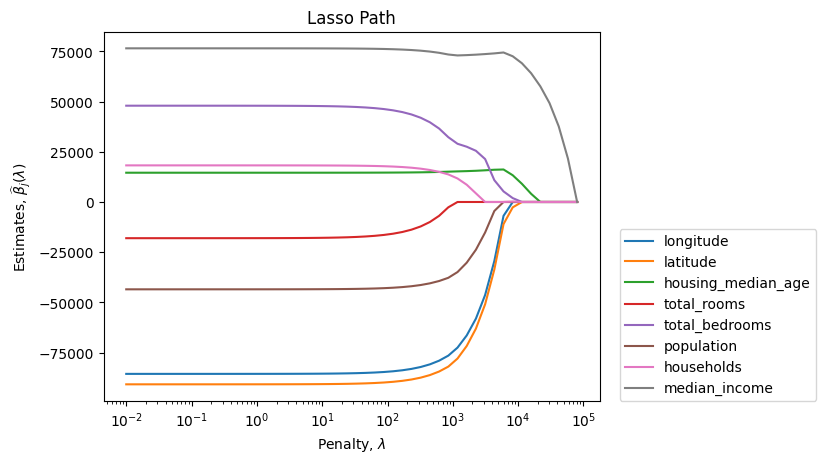

### Question 4: Cross Validation - penalty $\lambda$
Compute the penalty level and estimates implied by 5-fold cross-validation (5-CV). Which variables are selected by 5-CV? 

*Note 1:* Use sklearn.linear_model.LassoCV to estimate using Lasso with 5-CV. This is already loaded in as LassoCV.

*Note 2:* The argument "alphas" sets the grid of penalty levels that the 5-CV procedure will consider.

In [ ]:
# Align feature names with the standardized design used for estimation
Xnames = X_tilde.columns

# Estimate the model using LassoCV on the growth data
fit_CV = LassoCV(cv=5, alphas=penalty_grid).fit(X_tilde, y)

# Investigate the penalty
penalty_CV = fit_CV.alpha_
print('Penalty_CV: ', round(penalty_CV, 6))

# Investigate the coefficients
coeff_CV = fit_CV.coef_
print('Coefficients: ', np.round(coeff_CV, 6))

# Investigate the selected variables
selected_variables = (coeff_CV != 0)
print('Selected variables: ', Xnames[selected_variables].to_list()) 

You should get penalty_CV = 0.01

What does this error path suggest about the relationship between model sparsity and predictive power?

### Question 5: Visualize the estimates resulting from 5-CV

Consider the path of mean squared errors (MSE) for different penalty levels. Plot the mean MSE across folds as a function of the penalty level.

In [ ]:
# Retrieve CV grid and MSE for the growth model
penalties_CV = fit_CV.alphas_
MSE_CV = fit_CV.mse_path_.mean(axis=1)

In [ ]:
# Define a function that plots the CV MSE as a function of the penalty parameter for the growth model
def plot_MSE_path(penalty_grid, MSE):
    """
    Plot the mean cross-validated MSE as a function of the Lasso penalty (GDP growth model).

    Parameters:
    penalty_grid (array-like): Penalty parameter values (alphas).
    MSE (array-like): Mean MSE across folds for each alpha (same order as penalty_grid).
    """
    fig, ax = plt.subplots()

    ax.plot(penalty_grid, MSE, marker='o', ms=3, lw=1)
    ax.set_xscale('log')

    # Mark the minimum MSE
    min_idx = int(np.nanargmin(MSE))
    min_penalty = penalty_grid[min_idx]
    ax.axvline(x=min_penalty, linestyle='--', color='grey')

    ymin, ymax = ax.get_ylim()
    ytext = ymin + 0.95 * (ymax - ymin)
    ax.text(min_penalty, ytext, 'Minimum CV-MSE', rotation=90, va='top', ha='center', color='grey', fontsize='small')

    plt.xlabel('Penalty, $\\lambda$')
    plt.ylabel('CV mean squared error')
    plt.title('CV error path (GDP growth)')
    plt.show()
    plt.close()


In [ ]:
# Plot MSE as a function of the penalty parameter
plot_MSE_path(penalties_CV, MSE_CV)

What does this error path suggest about the relationship between model sparsity and predictive power? 

How is the penalty chosen when using CV?

Visualize the estimates resulting from 5-CV by adding a vertical line
to your Lasso path at the corresponding penalty level. Use vlines in plot_lasso_path to do this. How can you see which variables are selected by 5-CV?

In [ ]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames, vlines={'CV':penalty_CV})

### Question 6: BRT penalty
Compute the (feasible) Bickel-Ritov-Tsybakov (BRT) penalty level, the resulting Lasso estimates, and visualize them in your path. Compare the BRT results to the CV
ones. 

*Note 1:* scipy.stats.norm.ppf gives you the inverse of the normal CDF. scipy.stats.norm is already imported as norm.

*Note 2:* Use a significance level of 5%, and set c=1.1.

*Note 3:* Remember that python defines the LASSO slightly differently than we do. In particular, the penalty level is 1/2 of what we define it as.

*Note 4:* The max term in the BRT penalty is equal to 1 when data is standardized.

In [ ]:
X_tilde.mean(axis=0)

In [ ]:
# BRT penalty (growth.csv)
n = len(y)
p = X_tilde.shape[1]
sigma = np.std(y)
c = 1.1
alpha = 0.05

# With sample-standardized X (ddof=1), this is ≈ sqrt((n-1)/n)
max_term = np.sqrt(((X_tilde**2).sum(axis=0) / n).max())
print(max_term)

# sklearn Lasso objective: (1/(2n))||y-Xb||^2 + alpha||b||_1
penalty_BRT = c * sigma / np.sqrt(n) * norm.ppf(1 - alpha / (2*p))
print('Penalty_BRT: ', round(penalty_BRT, 6))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT).fit(X_tilde, y)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT, 6))

# Selected variables
selected_variables_BRT = (coeff_BRT != 0)
print('Selected variables: ', Xnames[selected_variables_BRT].to_list())

You should get penalty_BRT = 2428.92

In [ ]:
# Plot Lasso path for GDP growth (growth.csv)
vlines = {'CV': penalty_CV, 'BRT': penalty_BRT}
# Include BCCH if it has been computed (cell 36)
try:
    vlines['BCCH'] = penalty_BCCH
except NameError:
    pass

plot_lasso_path(penalty_grid, coefs, Xnames, vlines=vlines)

### Question 7: BCCH penalty
 Compute the Belloni-Chen-Chernozhukov-Hansen (BCCH) pilot and updated penalty levels, the resulting Lasso estimates, and add them to your path. Compare
the BCCH penalty and estimates to both the CV and BRT ones.

*Note 1:* Use a significance level of 5%, and set c=1.1.

In [ ]:
# BCCH pilot penalty
n,p = X.shape
c = 1.1
alpha = 0.05
yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_pilot: ', round(penalty_pilot, 2))

# Pilot estimates
#Create predicted value using Lasso 
pred = Lasso(alpha=penalty_pilot).fit(X_tilde,y).predict(X_tilde)

# Alternative: Manually
coeff_pilot = Lasso(alpha=penalty_pilot).fit(X_tilde,y).coef_
coef_intercept = Lasso(alpha=penalty_pilot).fit(X_tilde,y).intercept_
pred = (coef_intercept + X_tilde@coeff_pilot)

# Updated penalty
eps = y - pred 
epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
print('Penalty BCCH: ', round(penalty_BCCH, 2))

# Updated estimates
fit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_tilde,y)
coeff_BCCH = fit_BCCH.coef_
print('Coefficients: ', np.round(coeff_BCCH))

# Selected variables
selected_variables_BCCH = (coeff_BCCH != 0)
print('Selected variables: ', Xnames[selected_variables_BCCH].to_list())

You should get penalty_pilot = 4254.89

You should get penalty_BCCH = 1866.45

In [ ]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames, vlines={'CV':penalty_CV, 'BRT':penalty_BRT, 'BCCH':penalty_BCCH})

### Question 8: Summary of estimates $\hat{\boldsymbol{\beta}}$
Gather the estimates in a table.


In [ ]:
# Create pandas dataframe with variables in rows and CV, BRT and BCCH in columns
data = {'CV': coeff_CV, 'BRT': coeff_BRT, 'BCCH': coeff_BCCH}
df = pd.DataFrame(data, index=Xnames).astype(int)
print(df)

You should get something that looks like this...

| | CV | BRT | BCCH | 
|-|-|-|-|
| longitude	| -85613  | -55772 |	-63318 |
| latitude	| -90815  | -60676 | -68463 |
| housing_median_age | 14580   | 15594 | 15437 |
| total_rooms | -18027       | 0 |0 |
| total_bedrooms |	47962   |	24936 | 26764 |
| population |	-43498  | -21994 | -27803 |
| households |	18236    |	3115 | 6979 |
| median_income	| 76536   | 73438 | 73236 |


### Question 9 (Optional): Repeat with more regressors
Redo the entire exercise after having added squares of the basic regressors. Note that creating the Lasso path may take a while and the algorithm may fail to converge at low penalty levels. If so, try to change the number of iterations by adjusting max_iter. [Hints: Create squares and use numpy.hstack to add them to the regressors in levels. You may also use sklearn.preprocessing.PolynomialFeatures to further add interaction terms.]

In [ ]:
# Adding quadratics and normalizing anew
Xtech = np.hstack((X,X ** 2))
Xtechn = (Xtech - np.mean(Xtech,axis = 0))/np.std(Xtech,axis = 0)
lambda_grid = np.geomspace(10,1e5, num=50) # log-equispaced
from sklearn.linear_model import Lasso
coefs_tech=[]
for lamb in lambda_grid:
    fit=Lasso(alpha = lamb,max_iter=1000000).fit(Xtechn,y) # estimate
    coefs_tech.append(fit.coef_)
    
# save numpy array
np.save("coefs_tech.npy", coefs_tech)

In [ ]:
# load numpy array
coefs_tech = np.load("coefs_tech.npy")

In [ ]:
# CV
from sklearn.linear_model import LassoCV
fit_cv_tech=LassoCV(cv=5,max_iter=1000000).fit(Xtechn,y)
lambda_cv_tech=fit_cv_tech.alpha_

In [ ]:
n = 50
L = np.geomspace(0.001,80000,n)
fit_cv2 = LassoCV(cv=5,alphas=L, max_iter=1000000).fit(Xtechn,y)
lambda2_CV = fit_cv2.alpha_
print("chosen lambda by CV:", fit_cv2.alpha_)
print("Minimal possible lambda by CV:", np.min(fit_cv2.alphas_))

#error path 
plt.plot(fit_cv2.alphas_, np.mean(fit_cv2.mse_path_, axis=1))
plt.xlabel("lambda")
plt.ylabel("Mean squared error")
plt.show()

#Set lambda to a low value...
lambda_cv_tech = 10

In [ ]:
# BRT
# Penalty
from scipy.stats import norm
sigmahat = np.std(y)
n,pnew = Xtech.shape
c = 1.1; alpha = 0.05
lambda_brt_tech = c*sigmahat*norm.ppf(1-alpha/(2*pnew))/np.sqrt(n) 
# Note: Have divided by 2 due to Python definition of Lasso

# Implied estimates and selection
coef_brt_tech=Lasso(alpha=lambda_brt_tech, max_iter=1000000).fit(Xtechn,y).coef_
sel_brt_tech=(coef_brt_tech!=0)

# BCCH
# Pilot penalty
yXtechscale = (np.max((Xtechn.T ** 2) @ ((y - np.mean(y)) ** 2) / n)) ** 0.5
lambda_pilot_tech = c*norm.ppf(1-alpha/(2*pnew))*yXtechscale/np.sqrt(n)
# Note: Have divided by 2 due to Python definition of Lasso

# Pilot estimates
coef_pilot_tech = Lasso(alpha=lambda_pilot_tech, max_iter=1000000).fit(Xtechn,y).coef_
intercept_pilot_tech = Lasso(alpha=lambda_pilot_tech, max_iter=1000000).fit(Xtechn,y).intercept_

# Updated penalty
res_tech = y - (intercept_pilot_tech + Xtechn @ coef_pilot_tech)
resXtechscale = (np.max((Xtechn.T ** 2) @ (res_tech ** 2) / n)) ** 0.5
lambda_bcch_tech = c*norm.ppf(1-alpha/(2*pnew))*resXtechscale/np.sqrt(n)

# Updated estimates
coef_bcch_tech = Lasso(alpha=lambda_bcch_tech, max_iter=1000000).fit(Xtechn,y).coef_
sel_bcch_tech = (coef_bcch_tech != 0)

# Visualized along path
ax = plt.gca()
ax.plot(lambda_grid, coefs_tech) 
ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.title('Lasso Path (Std.Dev.s)')
ax.axvline(x=lambda_cv_tech,c='k',linestyle='--')
plt.text(lambda_cv_tech+2,-200000,'CV',rotation=90) 
ax.axvline(x=lambda_brt_tech,c='k',linestyle='--') 
plt.text(lambda_brt_tech+2,-200000,'BRT',rotation=90)
ax.axvline(x=lambda_bcch_tech,c='k',linestyle='--') 
plt.text(lambda_bcch_tech-600,-200000,'BCCH',rotation=90) 
plt.show()
# Note: Too crowded to be informative.

When it comes to the exact estimates, the resulting plot is here too crowded to be informative. But the plot still illustrates the expected order of the three penalty levels.

Compare your error path to the one you obtained in Question 4 - has the tradeoff between model sparsity and predictive power changed?